In [1]:
from warnings import filterwarnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

filterwarnings('ignore')
pd.set_option("display.max_columns",None)
pd.set_option("display.width",200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
# Amazon yorumları için duygu analizi veri seti
df = pd.read_excel("amazon.xlsx")
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


In [3]:
# Tüm harfleri küçük harfe çeviriyoruz
df['Review'] = df['Review'].str.lower()
df['Review']

0                                           happy with it
1       good quality material however the panels are m...
2       product was fun for bedroom windows.<br />imag...
3        lo unico que me gustaria es que sean un poco ...
4       great bang for the buck i can't believe the qu...
                              ...                        
5606    great product for reasonable money.  delivered...
5607             color is way off and panels do not match
5608    these are great for my studio as they compleme...
5609    brought out the beauty in kids room. they love...
5610    very cute curtains in my sons room! thick enou...
Name: Review, Length: 5611, dtype: object

In [4]:
# Noktalama işaretlerini çıkarıyoruz
df['Review'] = df['Review'].str.replace('[^\w\s]', '', regex=True)
df['Review']

0                                           happy with it
1       good quality material however the panels are m...
2       product was fun for bedroom windowsbr imagery ...
3        lo unico que me gustaria es que sean un poco ...
4       great bang for the buck i cant believe the qua...
                              ...                        
5606    great product for reasonable money  delivered ...
5607             color is way off and panels do not match
5608    these are great for my studio as they compleme...
5609     brought out the beauty in kids room they love it
5610    very cute curtains in my sons room thick enoug...
Name: Review, Length: 5611, dtype: object

In [5]:
# Sayısal verileri çıkarıyoruz
df['Review'] = df['Review'].str.replace('[\d]', '', regex=True)
df['Review']

0                                           happy with it
1       good quality material however the panels are m...
2       product was fun for bedroom windowsbr imagery ...
3        lo unico que me gustaria es que sean un poco ...
4       great bang for the buck i cant believe the qua...
                              ...                        
5606    great product for reasonable money  delivered ...
5607             color is way off and panels do not match
5608    these are great for my studio as they compleme...
5609     brought out the beauty in kids room they love it
5610    very cute curtains in my sons room thick enoug...
Name: Review, Length: 5611, dtype: object

In [6]:
# Bilgi içermeyen kelimeleri (stopwords) veriden çıkarıyoruz
import nltk

# İngilizce stopwords listesini yükleme
#nltk.download('stopwords')
sw = stopwords.words('english')
sw

df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
df['Review']

0                                                   happy
1         good quality material however panels mismatched
2       product fun bedroom windowsbr imagery bit stre...
3       lo unico que gustaria es que sean un poco mas ...
4       great bang buck cant believe quality material ...
                              ...                        
5606    great product reasonable money delivered quick...
5607                               color way panels match
5608    great studio complement entire theme studioliv...
5609                        brought beauty kids room love
5610      cute curtains sons room thick enough keep light
Name: Review, Length: 5611, dtype: object

In [7]:
# Az geçen kelimeleri veriden çıkarınız
temp_df = pd.Series(' '.join(df['Review']).split()).value_counts() # Frekans

drops = temp_df[temp_df <= 1]

df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))
df['Review'].head()

0                                                happy
1                 good quality material however panels
2    product fun bedroom windowsbr imagery bit stre...
3                            lo que es que un poco mas
4    great bang buck cant believe quality material ...
Name: Review, dtype: object

In [8]:
# Lemmatization (Kelimeleri Köklerine Ayrıma)
df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['Review'].head()

0                                                happy
1                  good quality material however panel
2    product fun bedroom windowsbr imagery bit stre...
3                              lo que e que un poco ma
4    great bang buck cant believe quality material ...
Name: Review, dtype: object

In [9]:
# Metin Görselleştirme (Text Visualization)
tf = df['Review'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index() # Kelime frekansı
tf.columns = ["words", "tf"]
tf.sort_values("tf",ascending=False)

,words,tf
58,curtain,2588.00
35,look,1531.00
108,love,1453.00
92,room,1129.00
152,like,1053.00
...,...,...
1941,nail,2.00
1942,salon,2.00
1945,write,2.00
1948,colorsbr,2.00


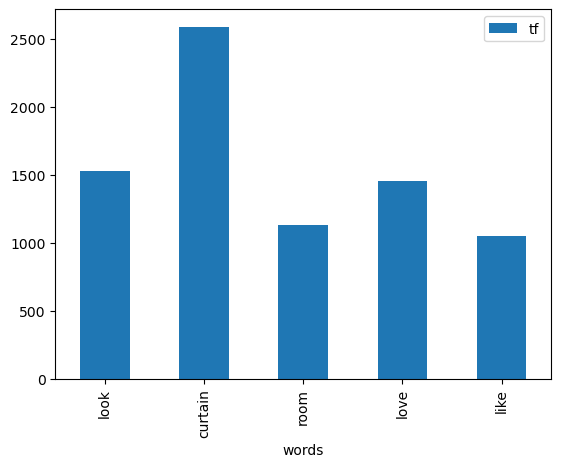

In [10]:
# Barplot 
tf[tf["tf"]  > 1000].plot.bar(x="words", y="tf")
plt.show()

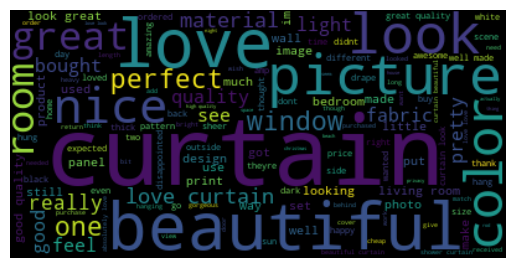

In [11]:
# Kelime Bulutu (Word Cloud)

text = " ".join(i for i in df.Review)
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [12]:
# Sentiment Analysis (Duygu Durum Analizi)  

sia = SentimentIntensityAnalyzer()

# "Review" değişkeninin ilk 10 gözlemi için polarity_scores() hesaplıyoruz
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x))
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

0   0.57
1   0.44
2   0.72
3   0.00
4   0.90
5   0.00
6   0.62
7   0.91
8   0.00
9   0.71
Name: Review, dtype: float64

In [13]:
# Verideki bütün yorumlara uyguladık
df["polarity_score"] = df["Review"].apply(lambda x: sia.polarity_scores(x)["compound"]) 
df["polarity_score"].tail(10)

5601   0.93
5602   0.49
5603   0.74
5604   0.87
5605   0.86
5606   0.77
5607   0.00
5608   0.79
5609   0.84
5610   0.46
Name: polarity_score, dtype: float64

In [14]:
# "Review" değişkenindeki tüm gözlemler için pos-neg atamasını yaparak yeni bir değişken oluşturduk
df['pos_neg'] = np.where(df['polarity_score'] > 0, 'pos', 'neg')
df.head()

,Star,HelpFul,Title,Review,polarity_score,pos_neg
0,5,0,looks great,happy,0.57,pos
1,5,0,Pattern did not align between the two panels.,good quality material however panel,0.44,pos
2,5,0,Imagery is stretched. Still fun.,product fun bedroom windowsbr imagery bit stre...,0.72,pos
3,5,0,Que se ven elegantes muy finas,lo que e que un poco ma,0.00,neg
4,5,0,Wow great purchase,great bang buck cant believe quality material ...,0.90,pos


In [15]:
from sklearn.model_selection import train_test_split
y = df["pos_neg"] # Bağımlı Değişken Label
x = df["Review"] # Bağımsız Değişken (Metin)

# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [16]:
# Metin verilerini sayısal değere dönüştürmek
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer().fit(X_train)

# Eğitim verisini kullanarak fit etmek
X_train_tfidf = vectorizer.transform(X_train)
# Eğitim ve test verilerine transform uygulamak
X_test_tfidf = vectorizer.transform(X_test)

In [17]:
log_model = LogisticRegression()
log_model.fit(X_train_tfidf, y_train)

cv_scores = cross_val_score(log_model, X_train_tfidf, y_train, scoring="accuracy", cv=10)
mean_cv_score = cv_scores.mean()
print("Çapraz Doğrulama Ortalama Skoru:", mean_cv_score)

Çapraz Doğrulama Ortalama Skoru: 0.8913969008030765


In [18]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = log_model.predict(X_test_tfidf)

# Karışıklık matrisini ve sınıflandırma raporunu yazdırma
print("Karışıklık Matrisi:")
print(confusion_matrix(y_test, y_pred))

print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

Karışıklık Matrisi:
[[  81  143]
 [   7 1172]]

Sınıflandırma Raporu:
              precision    recall  f1-score   support

         neg       0.92      0.36      0.52       224
         pos       0.89      0.99      0.94      1179

    accuracy                           0.89      1403
   macro avg       0.91      0.68      0.73      1403
weighted avg       0.90      0.89      0.87      1403



In [19]:
from sklearn.model_selection import cross_val_score

# Çapraz doğrulama uygulama
cv_scores = cross_val_score(log_model, X_train_tfidf, y_train, scoring="accuracy", cv=10)

# Ortalama çapraz doğrulama skoru hesaplama
mean_cv_score = cv_scores.mean()

print("Çapraz Doğrulama Ortalama Doğruluk Skoru:", mean_cv_score)


Çapraz Doğrulama Ortalama Doğruluk Skoru: 0.8913969008030765


In [83]:
# "Review" değişkeni içerisinden örneklem seçilerek tahmin
random_review = df["Review"].sample(1).values[0]
print(random_review)
vectorizer = TfidfVectorizer().fit(X_train)
random_review_tfidf = vectorizer.transform([random_review])
prediction = log_model.predict(random_review_tfidf)
print(prediction)

beautiful look like real wood
['pos']


In [21]:
# Random Forest
rf_model = RandomForestClassifier().fit(X_train_tfidf, y_train)
cross_val_score(rf_model, X_train_tfidf, y_train, cv=5, n_jobs=-1).mean()

0.913018095751862

In [22]:
rf_model = RandomForestClassifier(random_state=17)

rf_params = {"max_depth":[8,None],
             "max_features":[7,"auto"],
             "min_samples_split":[2,5,8],
             "n_estimators":[100,200]}

rf_best = GridSearchCV(rf_model,rf_params,cv=5,n_jobs=-1,verbose=True).fit(X_train_tfidf,y_train)

print(rf_best.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'max_depth': None, 'max_features': 'auto', 'min_samples_split': 8, 'n_estimators': 200}


In [23]:
# Final Model #
rf_final = rf_model.set_params(**rf_best.best_params_, random_state=17).fit(X_train_tfidf,y_train)
cross_val_score(rf_final,X_train_tfidf,y_train,cv=5,n_jobs=-1).mean()

0.9120691067358451

In [24]:
y_pred = rf_final.predict(X_test_tfidf)

# Karışıklık matrisini ve sınıflandırma raporunu yazdırma
print("Karışıklık Matrisi:")
print(confusion_matrix(y_test, y_pred))

print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

Karışıklık Matrisi:
[[ 124  100]
 [  31 1148]]

Sınıflandırma Raporu:
              precision    recall  f1-score   support

         neg       0.80      0.55      0.65       224
         pos       0.92      0.97      0.95      1179

    accuracy                           0.91      1403
   macro avg       0.86      0.76      0.80      1403
weighted avg       0.90      0.91      0.90      1403



In [115]:
random_review = df["Review"].sample(1).values[0]
print(random_review)
vectorizer = TfidfVectorizer().fit(X_train)
random_review_tfidf = vectorizer.transform([random_review])
prediction = rf_final.predict(random_review_tfidf)
print(prediction)

nice
['pos']
